# **Edmonton Food Drive 2024 - ML Development and Evaluation**

## **Introduction**
The Edmonton Food Drive is a collaborative initiative designed to tackle food insecurity in Edmonton. This drive ​mobilizes volunteers and resources to collect and distribute food to those in need. By leveraging machine learning, ​the project aims to enhance operational efficiency and maximize the impact of each donation. The integration of ​real-time data and optimized routing will contribute to a more streamlined and effective food distribution process.

**Team Name:** Team 404

**Team Members:**
*   Catrina Llamas
*   Roe Joshua Alincastre
*   Kendrick Moreno

#### **Task 1: Imports and data loading**
Now lets import required libraries that we are going to use throughout this project.

In [29]:
import os
import yaml
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from utils.open_config import load_config
from train import Trainer
from preprocess import DataLoader, DataCleaner, FeatureEngineer, DataMerger, DataSplitter

##### **Load the dataset**
We are going to load the cleaned dataset.

In [30]:
params, project_root = load_config()
base_path = project_root
df_efd_cleaned = pd.read_csv(os.path.join(base_path, params["files"]["cleaned_data"]))
df_efd_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0.1             1045 non-null   int64  
 1   Unnamed: 0               1045 non-null   int64  
 2   Drop Off Location        1045 non-null   object 
 3   Stake                    1045 non-null   object 
 4   Route Information        1045 non-null   object 
 5   Time Spent               1045 non-null   int64  
 6   Total Adult Volunteers   1045 non-null   float64
 7   Total Youth Volunteers   1045 non-null   float64
 8   Number of Doors          1045 non-null   float64
 9   Number of Donation Bags  1045 non-null   float64
 10  Number of Routes         1045 non-null   float64
 11  Ward                     1045 non-null   object 
 12  Year                     1045 non-null   int64  
 13  Latitude                 1041 non-null   float64
 14  Longitude               

#### **Task 2: Feature Selection**

Lets check the correlation of our chosen features.

In [31]:
df_selected = df_efd_cleaned[['Time Spent', 'Number of Doors', 'Number of Donation Bags',
                                'Number of Routes', 'Ward', 'Year',
                                'Total Volunteers', 'Donation Bags per Door',
                                'Donation Bags per Route']]

Lets have a quick look on the correlation map of our selected features.

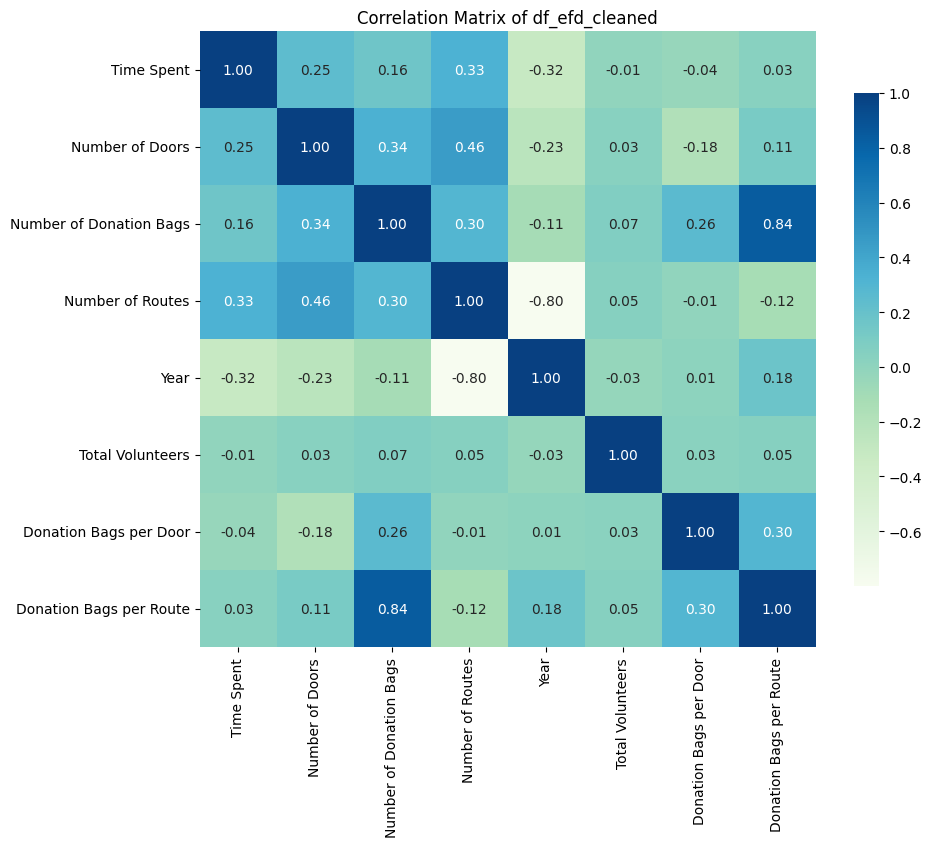

In [32]:
numeric_df = df_selected.select_dtypes(include=['int64', 'float64'])            # select only numeric columns for correlation
correlation_matrix = numeric_df.corr()                                          # create a correlation matrix
plt.figure(figsize=(10, 8))                                                     # set-up the size of the chart
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='GnBu',
            square=True, cbar_kws={"shrink": .8})                               # create a heatmap using seaborn
plt.title('Correlation Matrix of df_efd_cleaned')                               # add a title
plt.show()                                                                      # show the map

Lets check the distribution of each columns using pairplot

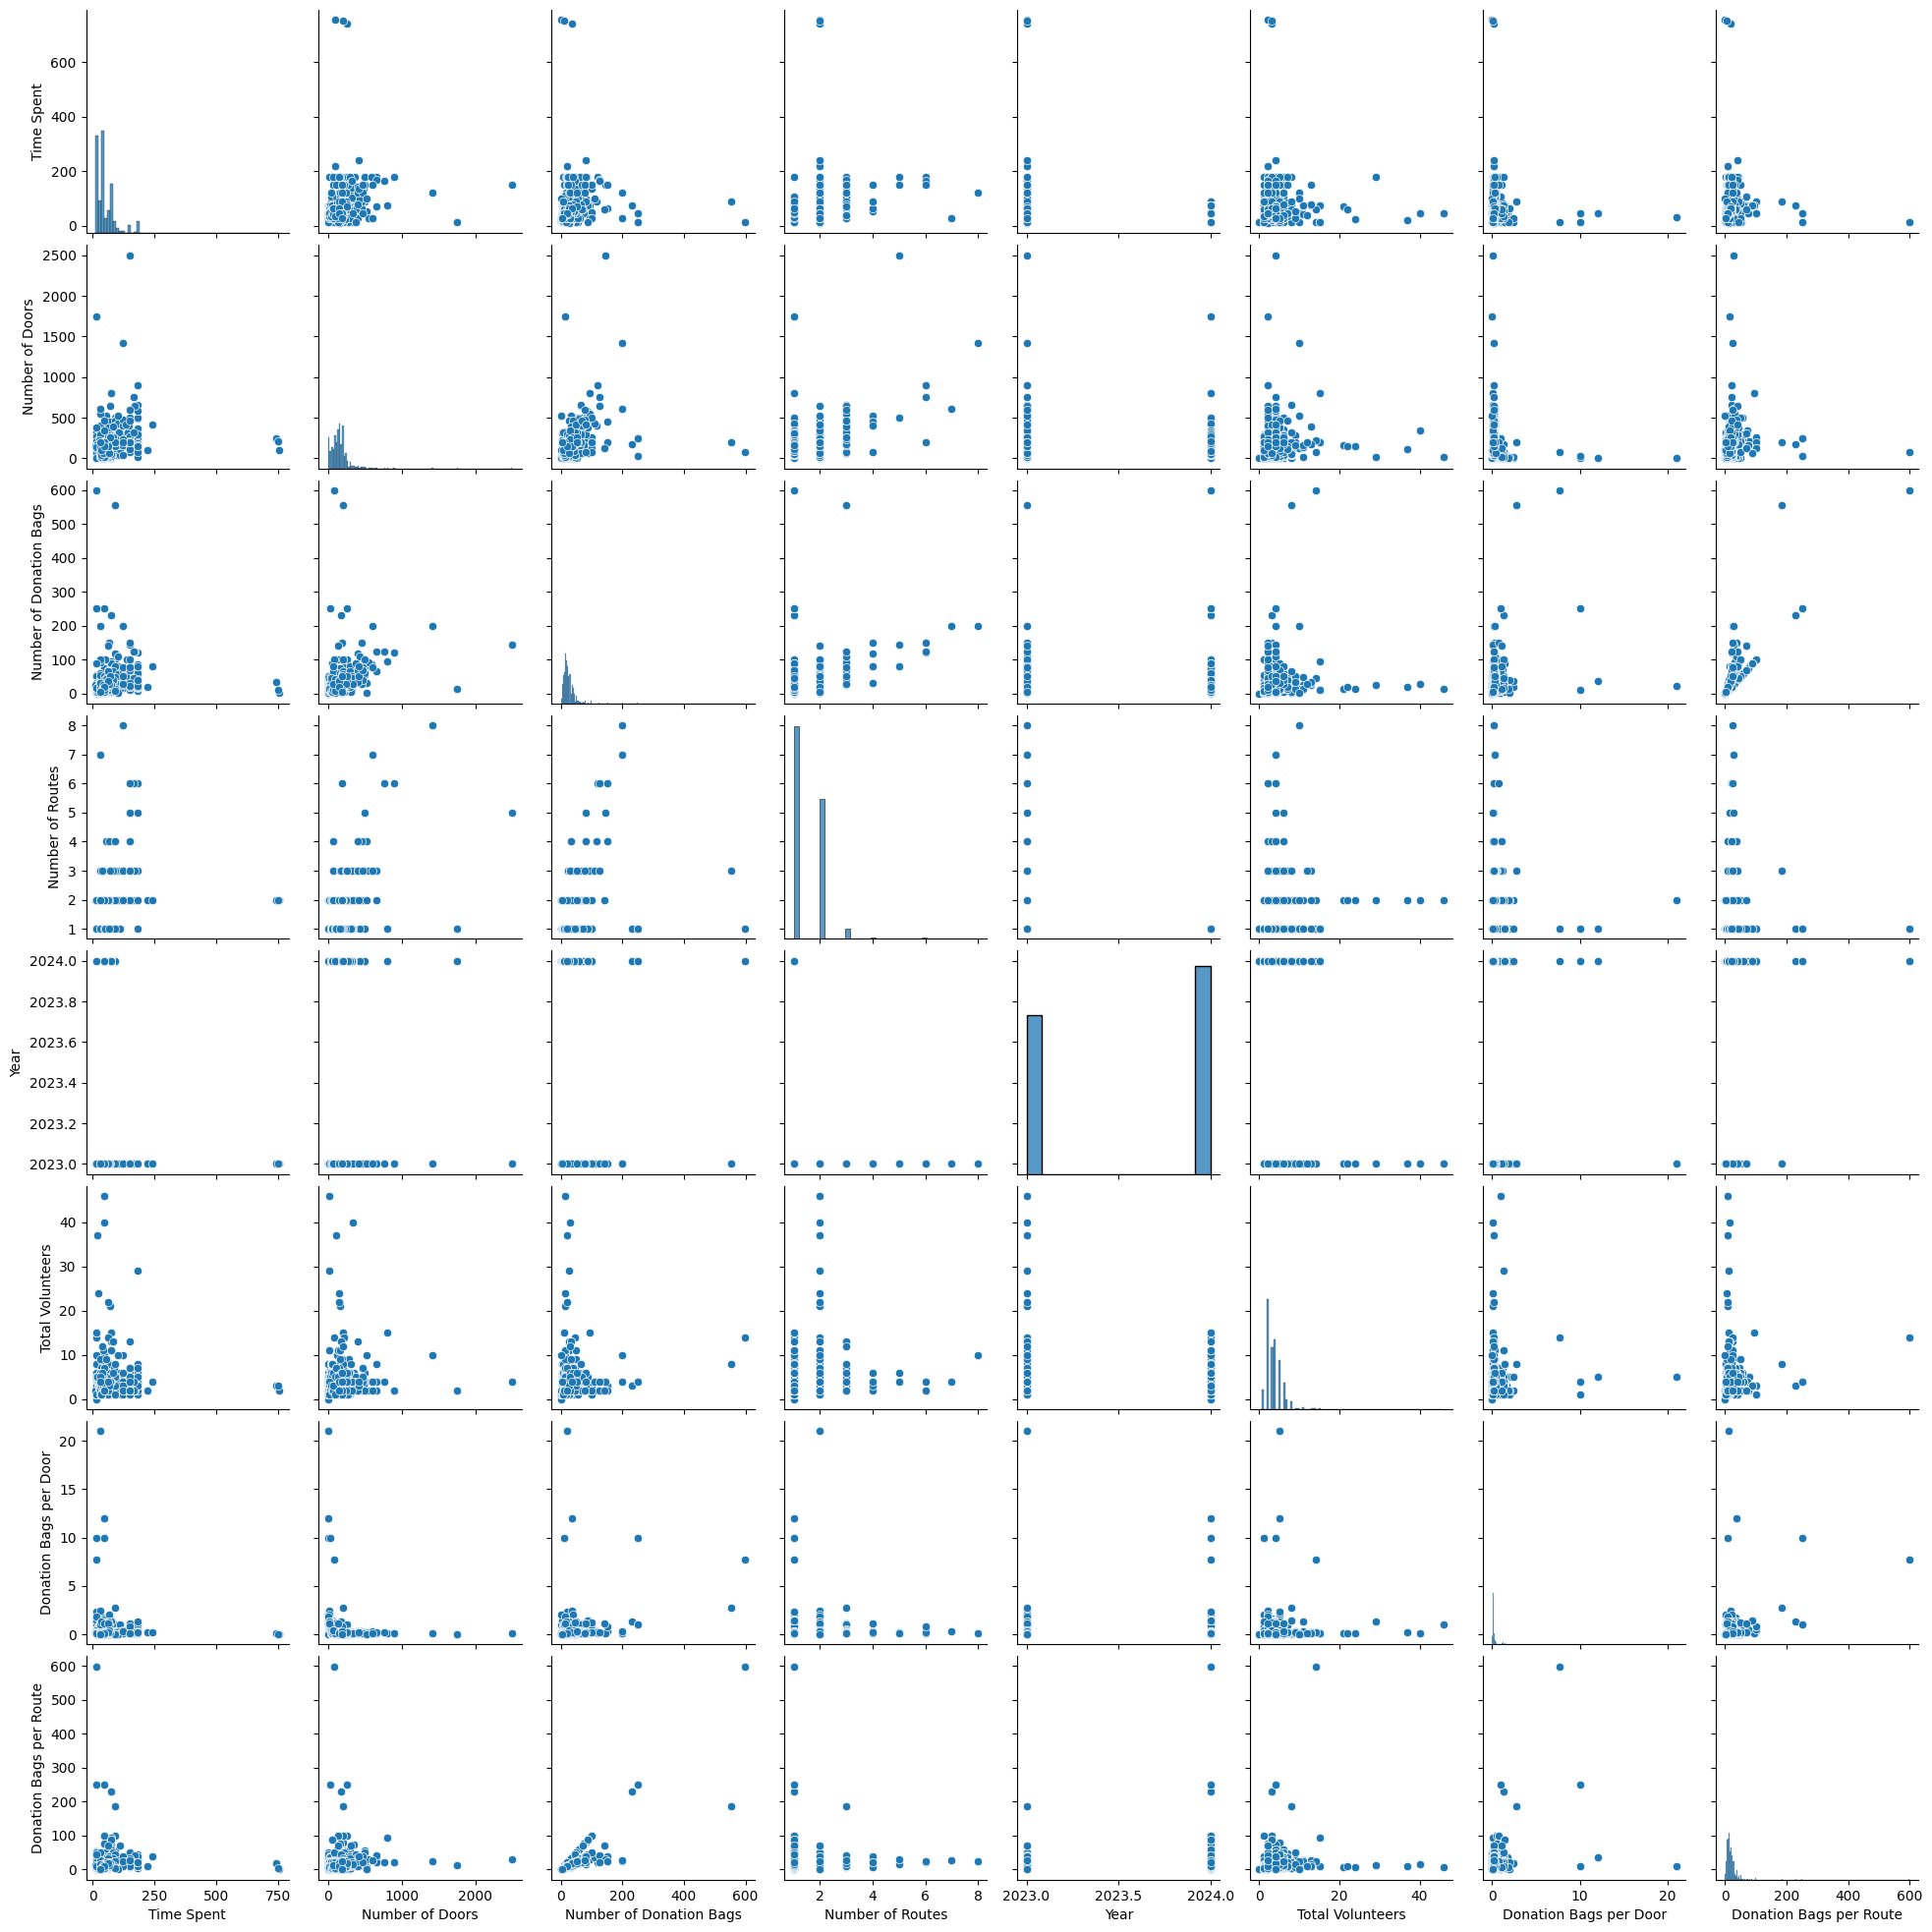

In [33]:
sns.pairplot(df_selected, palette="Greens")     
plt.show()                                      

#### **Task 3: Model Development and Evaluation: Forecast the total number of donation bags for each ward over the next five years**
In this section, we will develop multiple machine learning models to predict Total Donation Bags, including:
* Linear Regression
* Polynomial Regression
* Decision Tree Regression
* Random Forest Regression
* Gradient Boosting Machines (GBM)
* K-Nearest Neighbors (KNN)

First, let's split the data into training and testing sets to prepare for model evaluation.

In [34]:
data_splitter = DataSplitter(df_efd_cleaned)
X_train, y_train, X_test, y_test = data_splitter.split_data()

Next, we will define our preprocessor, applying one-hot encoding to categorical features and normalizing the selected numerical features.

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean'))  # Handle missing values
        ]), ['Number of Doors', 'Number of Routes', 'Year',
             'Total Volunteers', 'Donation Bags per Door', 'Time Spent']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Ward'])
    ]
)

Before initializing and training the six models, let’s create a general function to evaluate and display the performance metrics for each model.

In [36]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, results_df=None):
    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

    # Print evaluation metrics
    print(f"Model: {model_name}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R^2): {r2:.4f}")
    print(f"Adjusted R-squared: {adjusted_r2:.4f}")
    print("-" * 50)

    # Add the metrics to the DataFrame
    metrics = {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R^2': r2,
        'Adjusted R^2': adjusted_r2
    }

    metrics_df = pd.DataFrame([metrics])

    if results_df is None:
        results_df = metrics_df
    else:
        results_df = pd.concat([results_df, metrics_df], ignore_index=True)

    # Create subplots for visualizations
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))

    # Residual Plot
    residuals = y_test - y_pred
    sns.residplot(x=y_pred, y=residuals, lowess=True, color='blue', ax=axs[0, 0])
    axs[0, 0].set_xlabel('Predicted Values')
    axs[0, 0].set_ylabel('Residuals')
    axs[0, 0].set_title('Residual Plot')

    # Actual vs Predicted Plot
    axs[0, 1].scatter(y_test, y_pred, alpha=0.6)
    axs[0, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
    axs[0, 1].set_xlabel('Actual Values')
    axs[0, 1].set_ylabel('Predicted Values')
    axs[0, 1].set_title('Actual vs Predicted Values')

    # Residual Distribution
    sns.histplot(residuals, kde=True, bins=30, color='purple', ax=axs[1, 0])
    axs[1, 0].set_xlabel('Residuals')
    axs[1, 0].set_title('Distribution of Residuals')

    # Learning Curve
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5,
                                                            scoring='neg_mean_squared_error',
                                                            train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    axs[1, 1].plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    axs[1, 1].plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    axs[1, 1].set_xlabel('Training Size')
    axs[1, 1].set_ylabel('Mean Squared Error')
    axs[1, 1].set_title('Learning Curve')
    axs[1, 1].legend(loc='best')

    plt.tight_layout()
    plt.show()

    # Feature Importance (for tree-based models)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Get the feature names from the preprocessor
        feature_names = preprocessor.get_feature_names_out()

        plt.figure(figsize=(10, 6))
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
        plt.title('Feature Importance')
        plt.show()

    return results_df

**Linear Regression**

Model: Linear Regression
Mean Squared Error (MSE): 1343.0227
Root Mean Squared Error (RMSE): 36.6473
Mean Absolute Error (MAE): 19.7792
R-squared (R^2): -0.1917
Adjusted R-squared: -0.2665
--------------------------------------------------


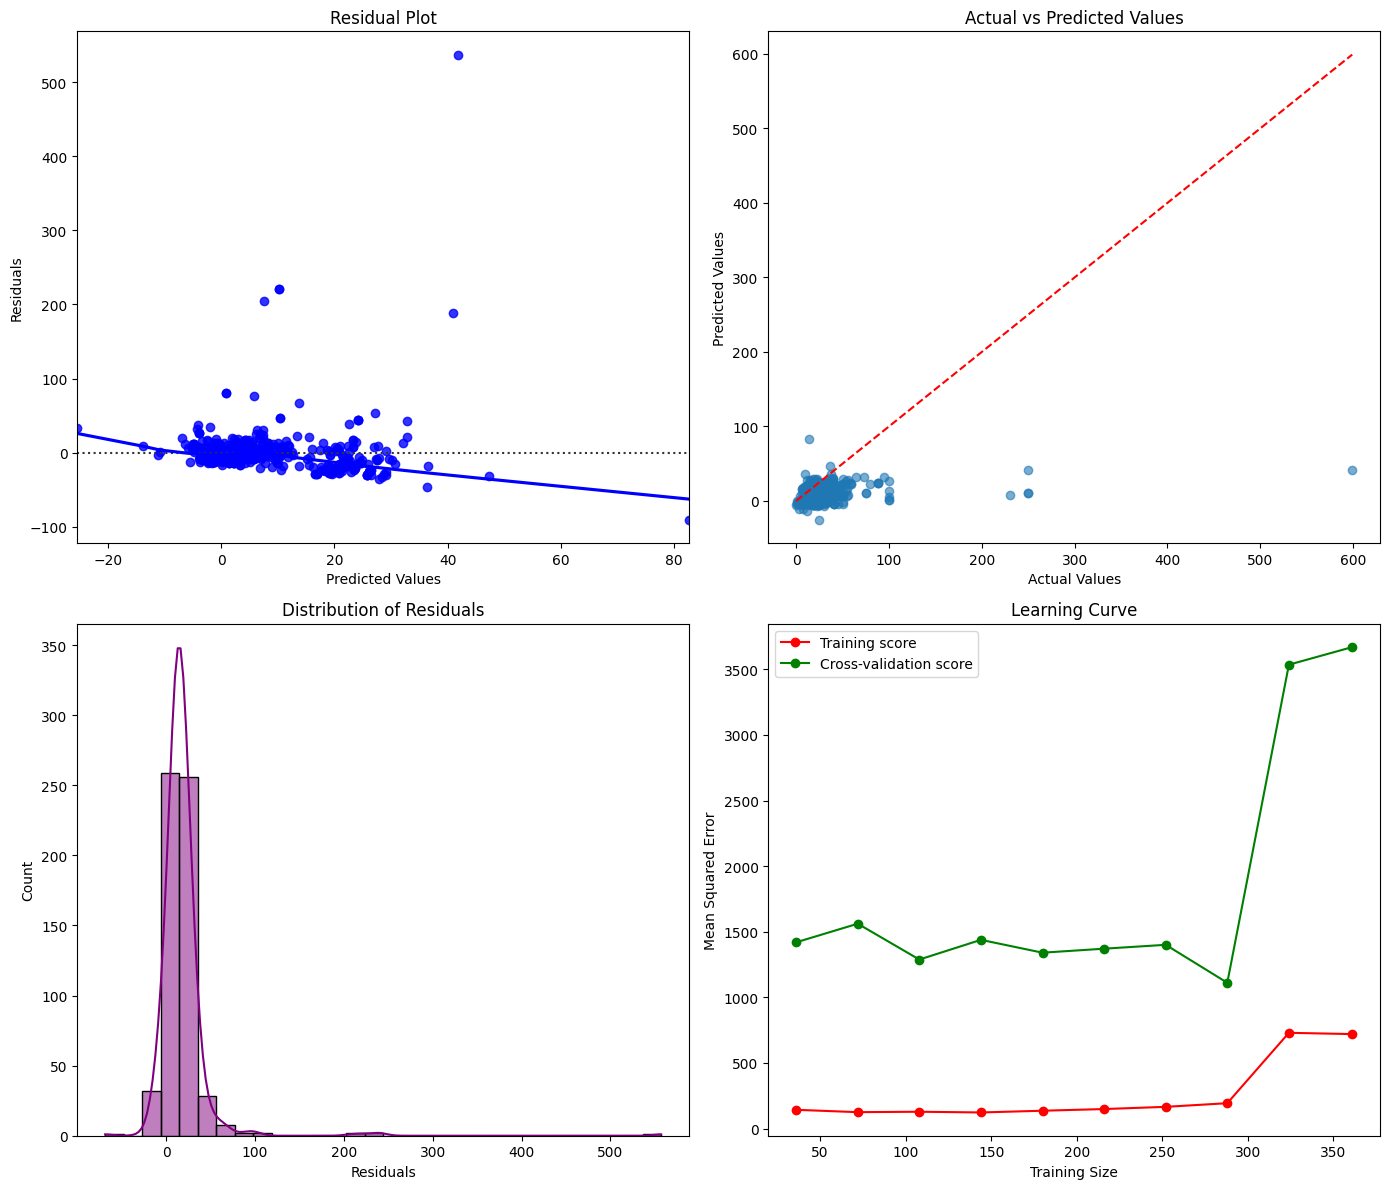

In [37]:
X_train_transformed_lm = preprocessor.fit_transform(X_train)
X_test_transformed_lm = preprocessor.transform(X_test)
lm = LinearRegression()
lm.fit(X_train_transformed_lm, y_train)
wards_results_df = pd.DataFrame()
wards_results_df = evaluate_model(lm, X_train_transformed_lm, X_test_transformed_lm, y_train, y_test, 'Linear Regression', wards_results_df)

**Polynomial Regression**

Model: Polynomial Regression
Mean Squared Error (MSE): 27.2581
Root Mean Squared Error (RMSE): 5.2209
Mean Absolute Error (MAE): 1.9234
R-squared (R^2): 0.9758
Adjusted R-squared: 1.1935
--------------------------------------------------


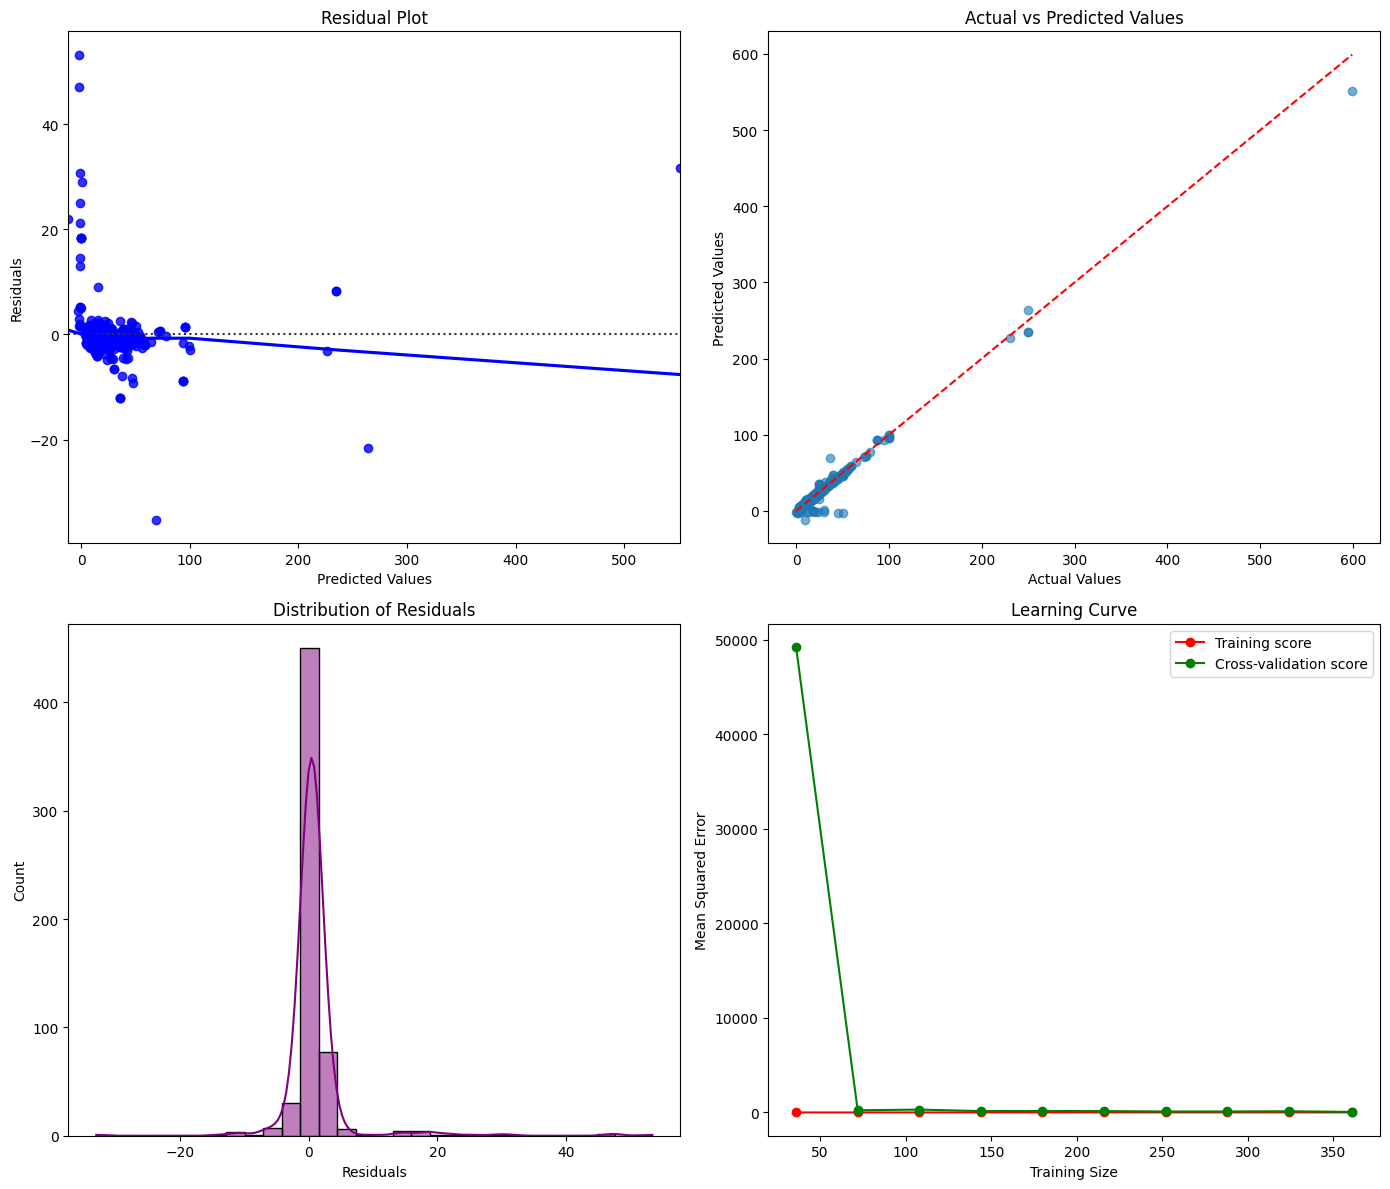

In [38]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_transformed)
X_test_poly = poly.transform(X_test_transformed)
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
wards_results_df = evaluate_model(poly_reg, X_train_poly, X_test_poly, y_train, y_test, 'Polynomial Regression', wards_results_df)

**Decision Tree Regression**

Model: Decision Tree Regression
Mean Squared Error (MSE): 684.7385
Root Mean Squared Error (RMSE): 26.1675
Mean Absolute Error (MAE): 5.3669
R-squared (R^2): 0.3924
Adjusted R-squared: 0.3543
--------------------------------------------------


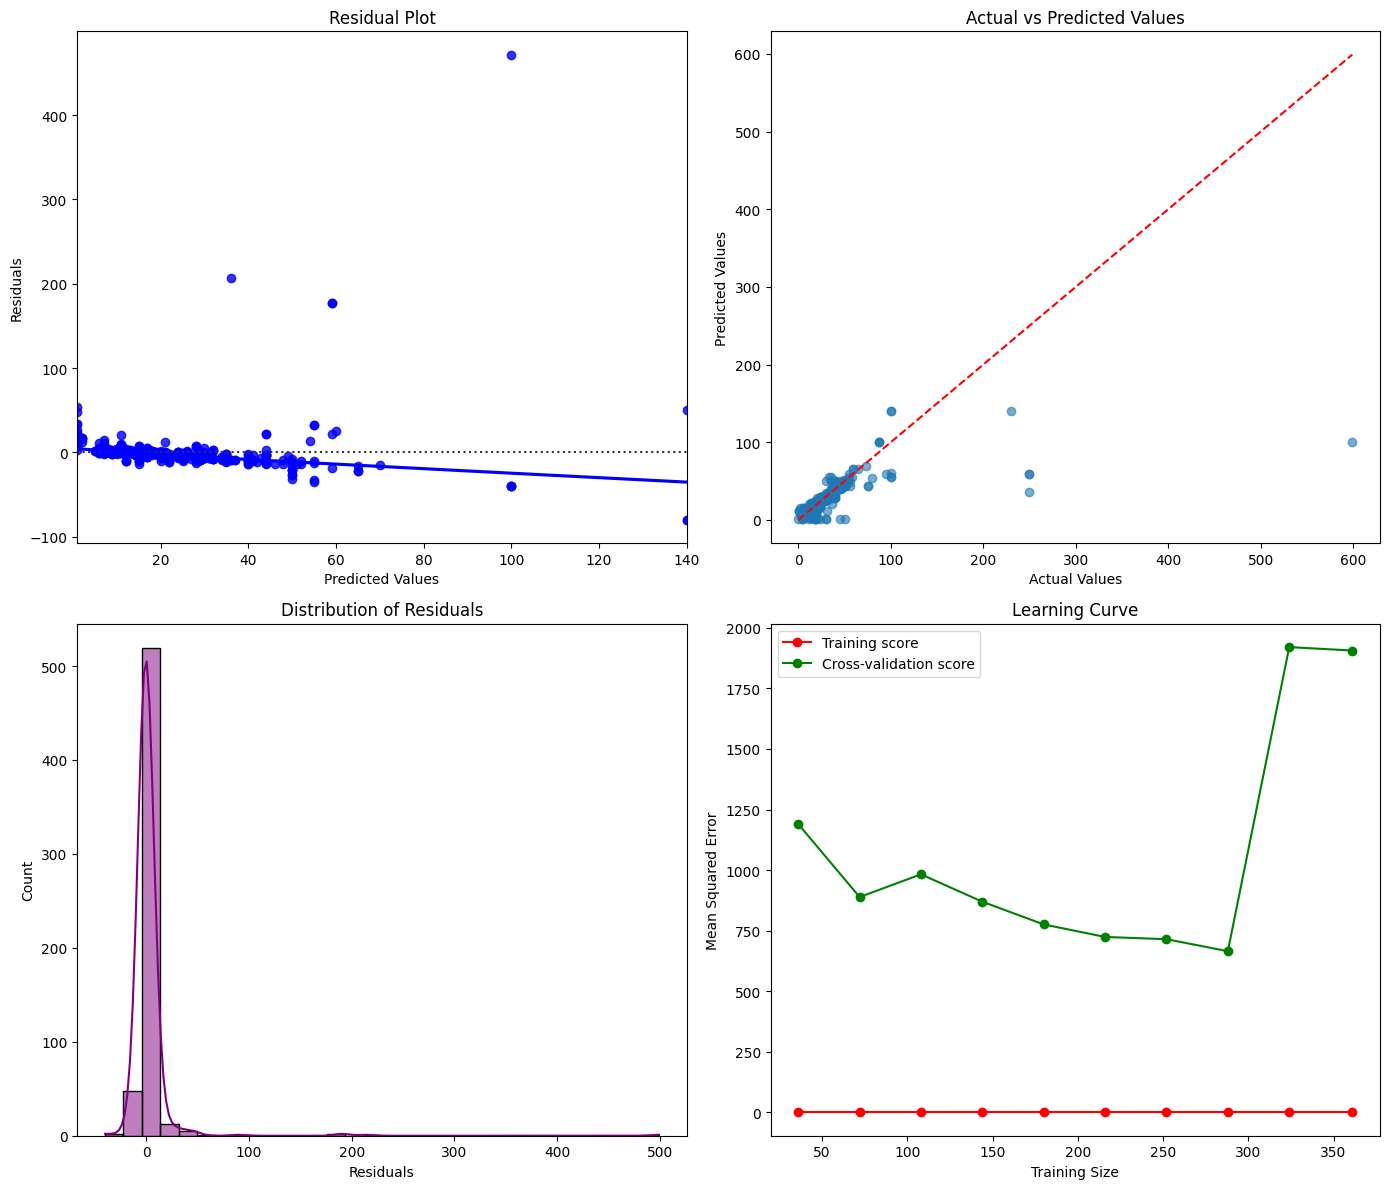

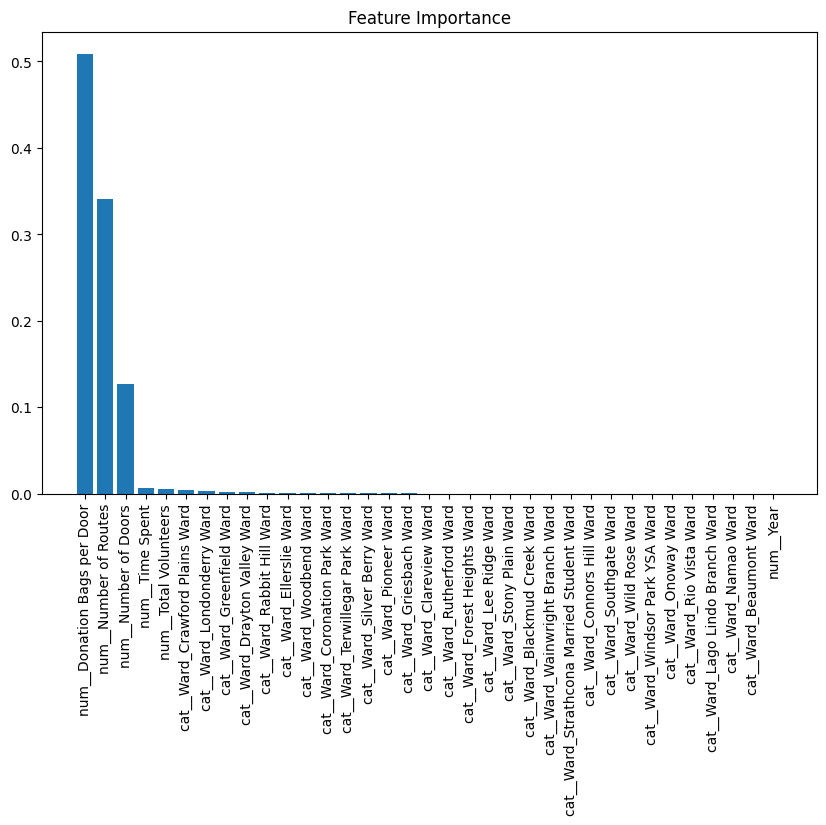

In [39]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train_transformed, y_train)
wards_results_df = evaluate_model(dt_reg, X_train_transformed, X_test_transformed, y_train, y_test, 'Decision Tree Regression', wards_results_df)

**Random Forest Regression**

Model: Random Forest Regression
Mean Squared Error (MSE): 470.0112
Root Mean Squared Error (RMSE): 21.6797
Mean Absolute Error (MAE): 4.6571
R-squared (R^2): 0.5830
Adjusted R-squared: 0.5568
--------------------------------------------------


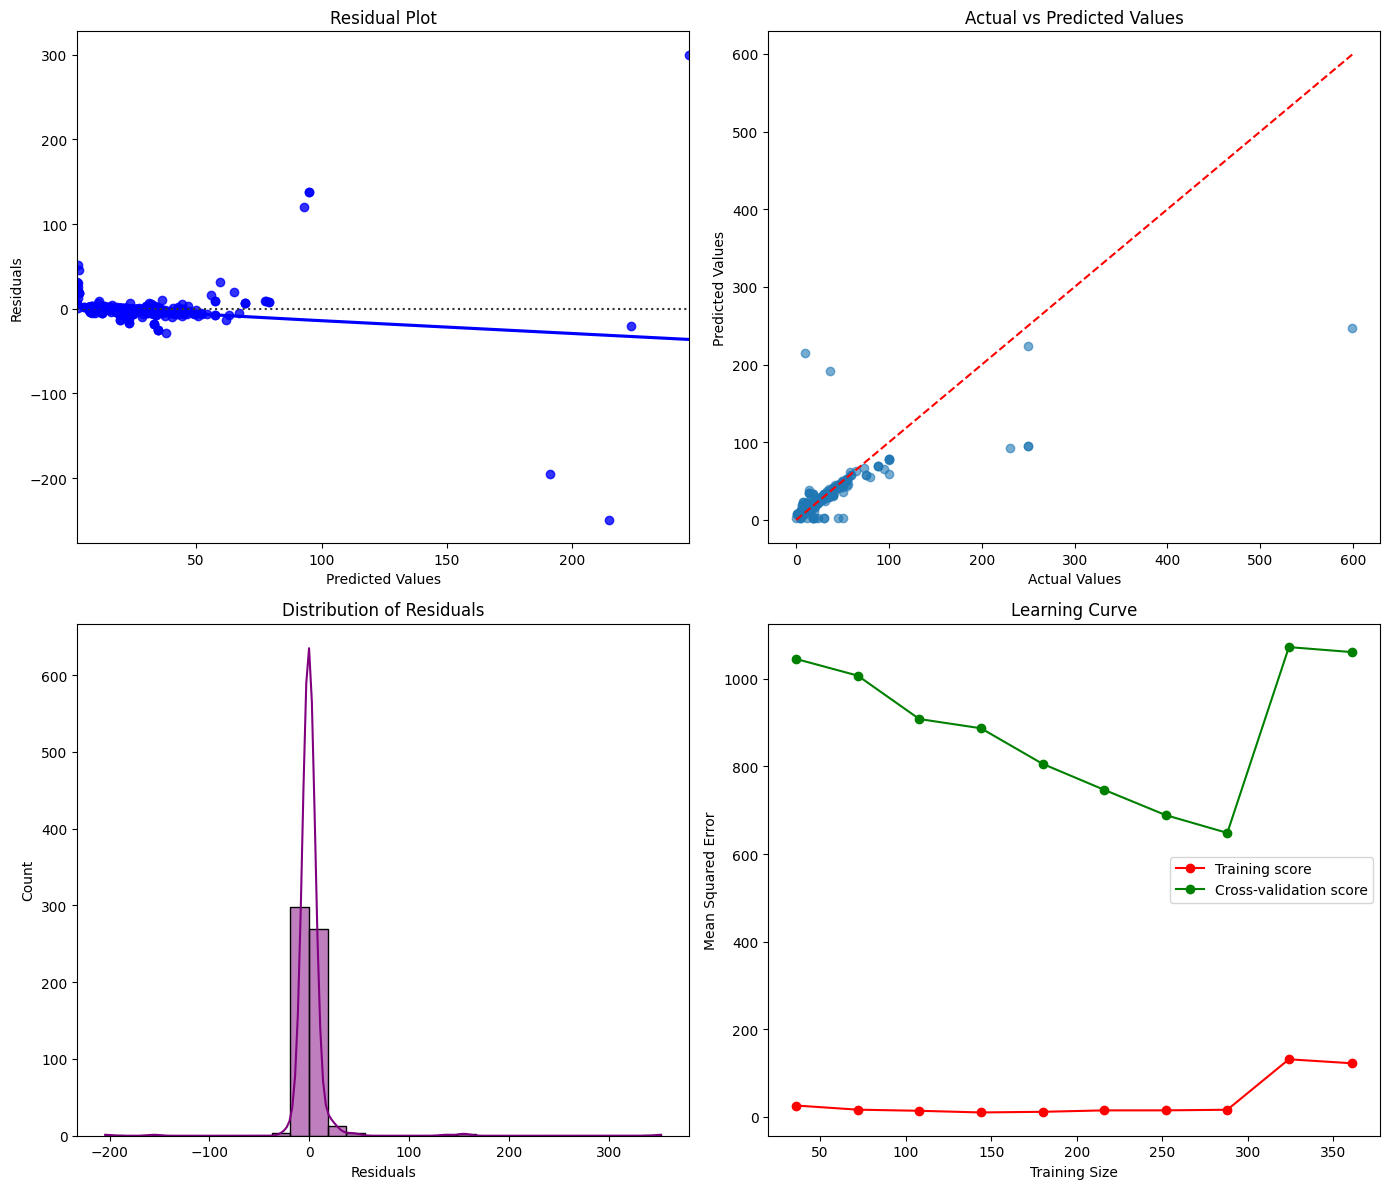

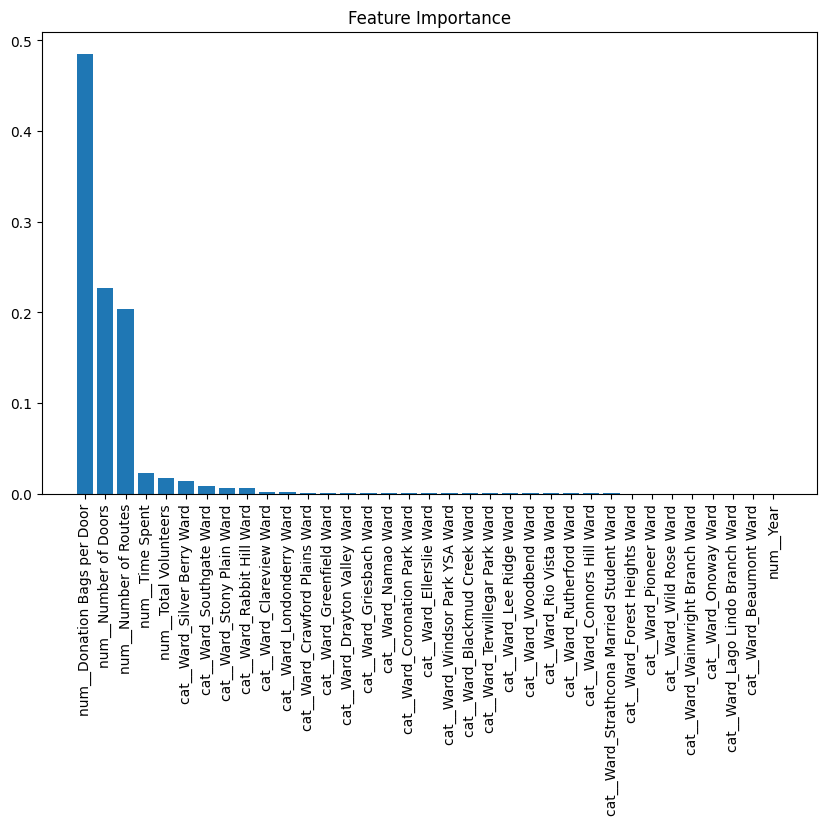

In [40]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_transformed, y_train)
wards_results_df = evaluate_model(rf_reg, X_train_transformed, X_test_transformed, y_train, y_test, 'Random Forest Regression', wards_results_df)

**Gradient Boosting Machines (GBM)**

Model: Gradient Boosting Regression
Mean Squared Error (MSE): 604.0749
Root Mean Squared Error (RMSE): 24.5779
Mean Absolute Error (MAE): 5.1340
R-squared (R^2): 0.4640
Adjusted R-squared: 0.4303
--------------------------------------------------


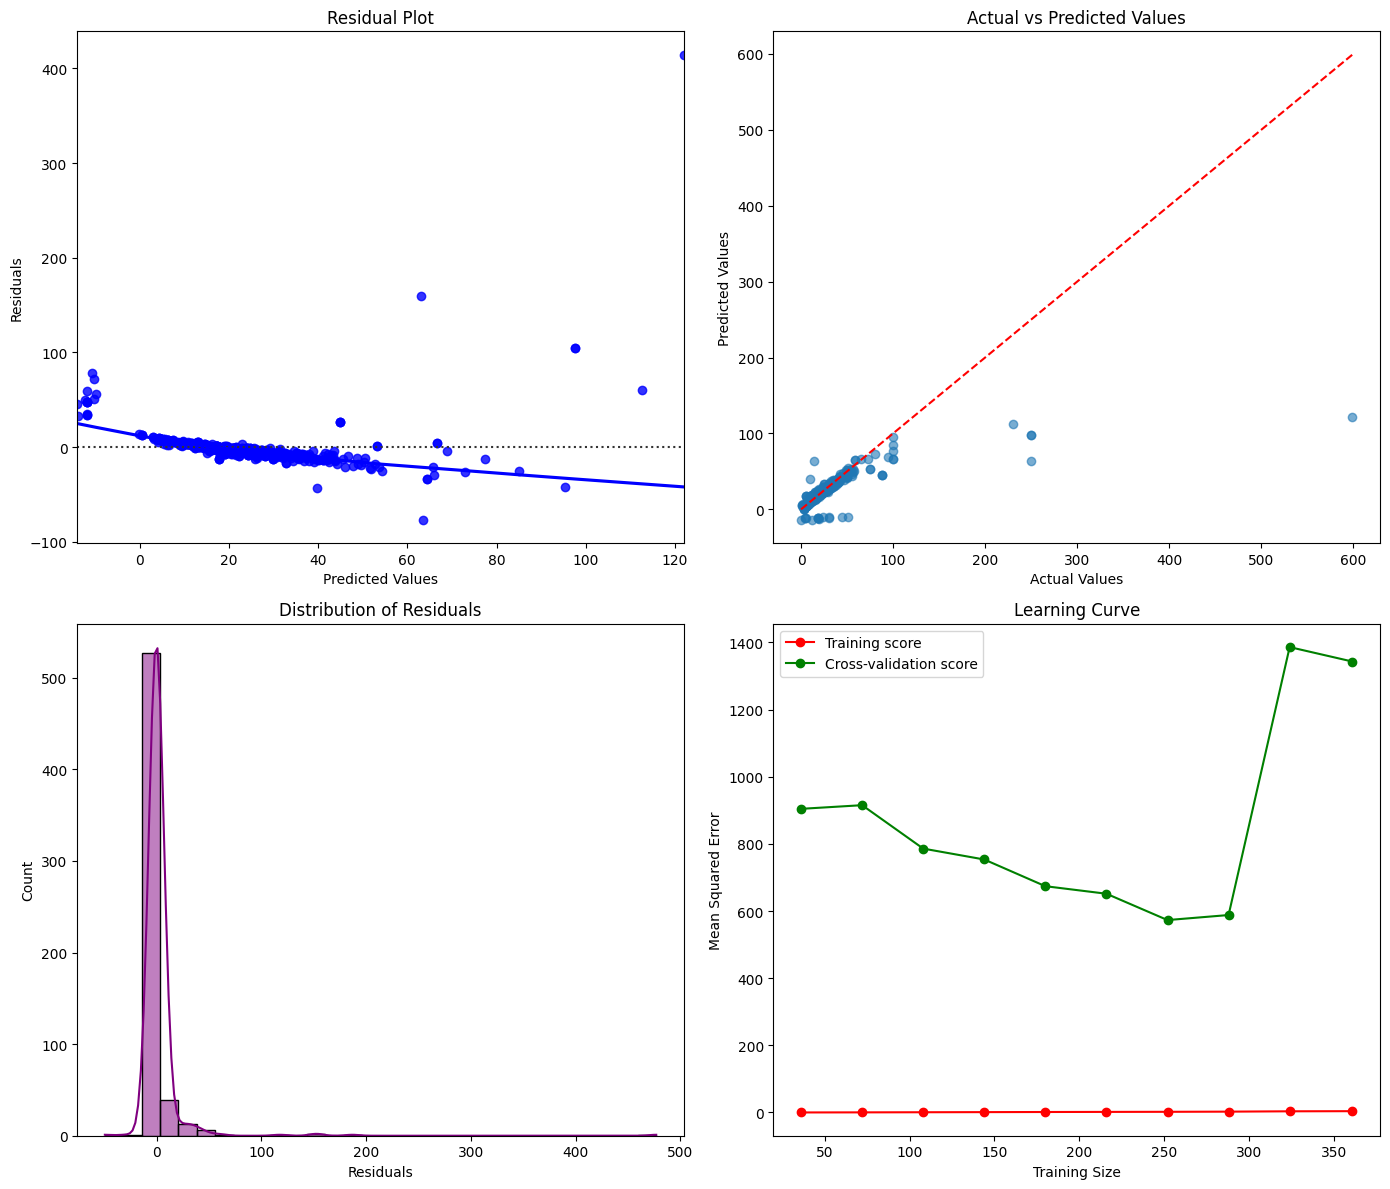

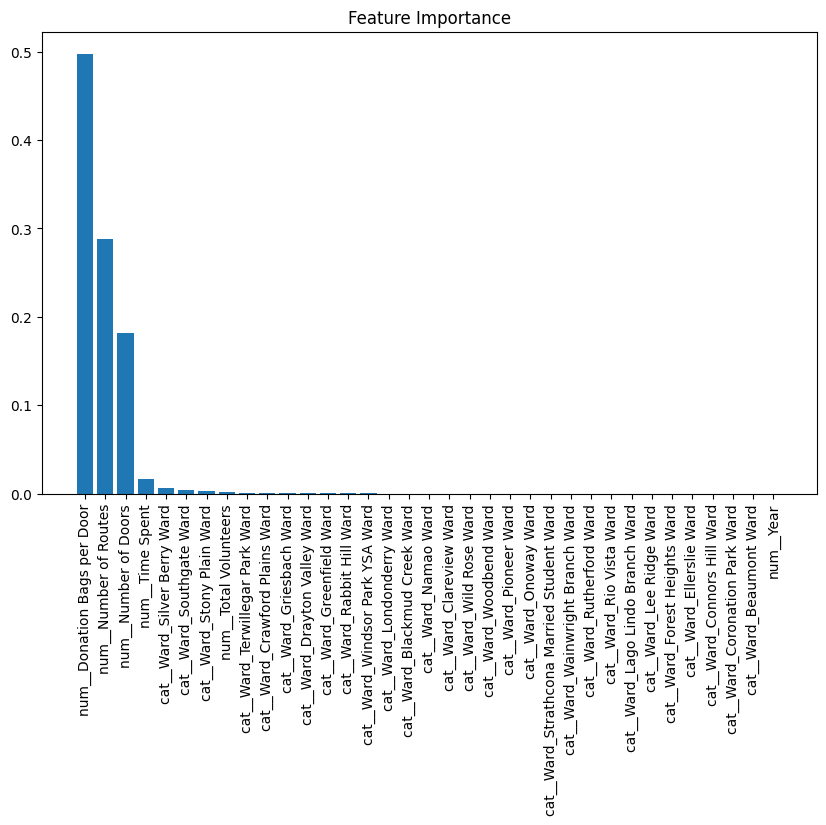

In [41]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
gbm_reg = GradientBoostingRegressor(random_state=42)
gbm_reg.fit(X_train_transformed, y_train)
wards_results_df = evaluate_model(gbm_reg, X_train_transformed, X_test_transformed, y_train, y_test, 'Gradient Boosting Regression', wards_results_df)

**K-Nearest Neighbors (KNN)**

Model: K-Nearest Neighbors Regression
Mean Squared Error (MSE): 1114.1790
Root Mean Squared Error (RMSE): 33.3793
Mean Absolute Error (MAE): 12.0510
R-squared (R^2): 0.0114
Adjusted R-squared: -0.0507
--------------------------------------------------


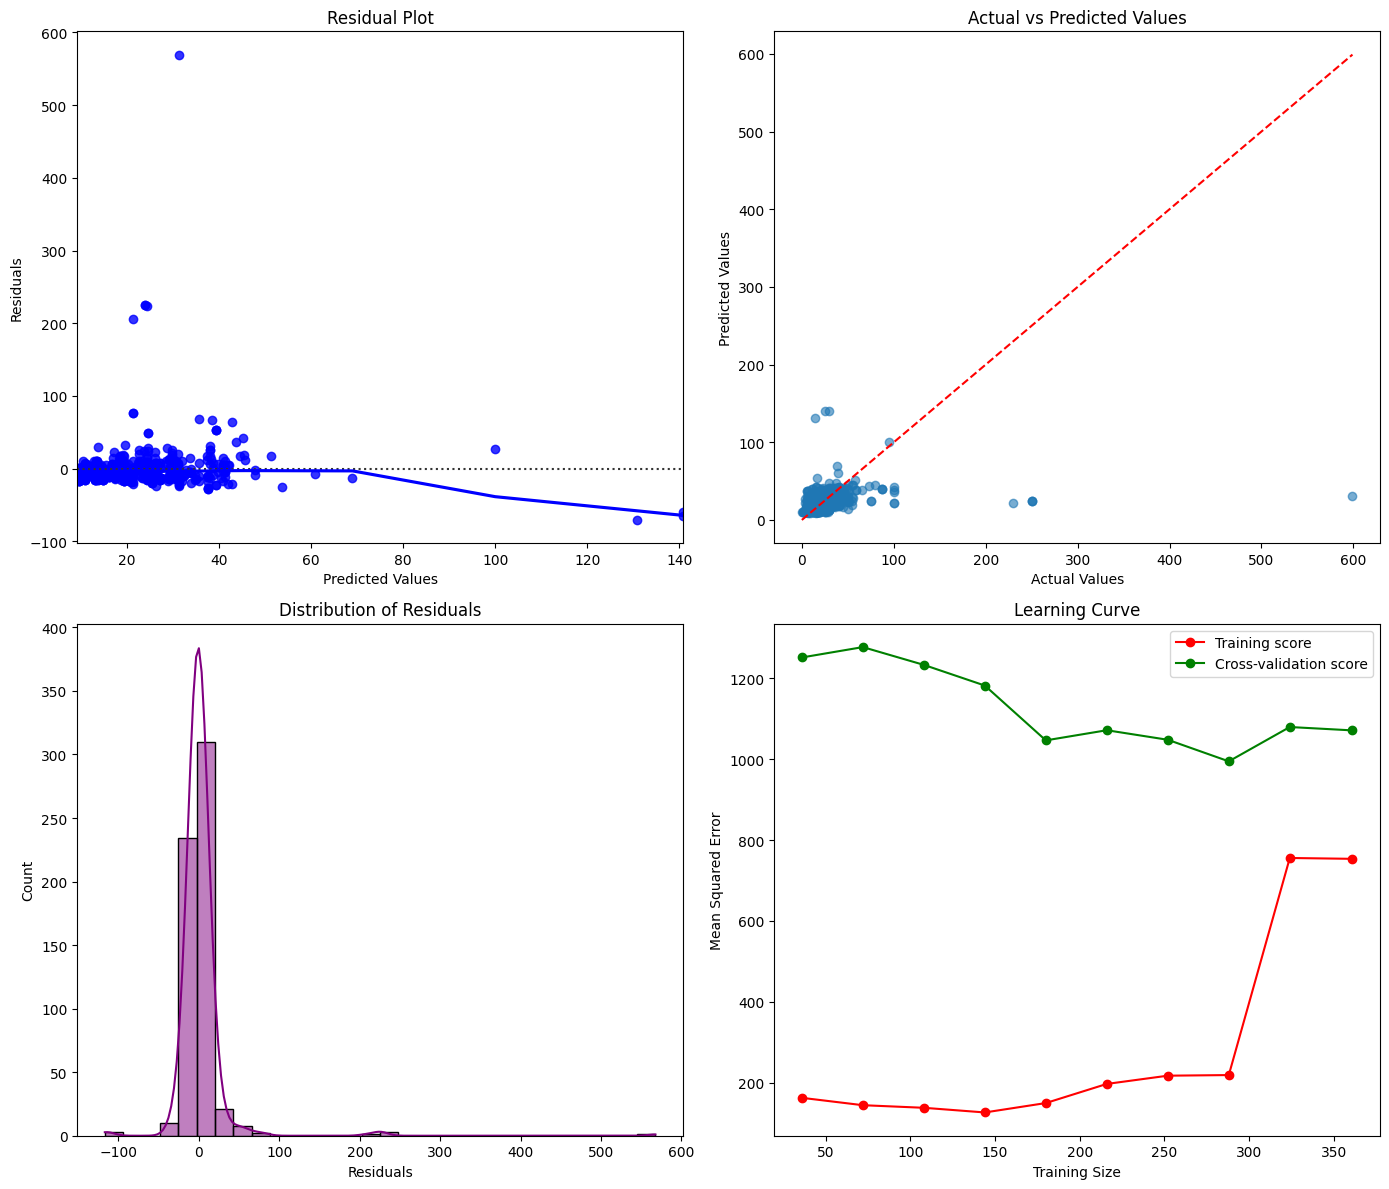

In [42]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train_transformed, y_train)
wards_results_df = evaluate_model(knn_reg, X_train_transformed, X_test_transformed, y_train, y_test, 'K-Nearest Neighbors Regression', wards_results_df)

#### **Task 4: Model Selection**
Now, let's evaluate the metrics for each model to determine which one performs best for our data.

In [43]:
wards_results_df

,Model,MSE,RMSE,MAE,R^2,Adjusted R^2
0,Linear Regression,1343.022688,36.647274,19.779202,-0.191666,-0.266546
1,Polynomial Regression,27.258087,5.220928,1.923355,0.975814,1.193489
2,Decision Tree Regression,684.738524,26.167509,5.366936,0.392431,0.354253
3,Random Forest Regression,470.011182,21.679741,4.657055,0.582959,0.556753
4,Gradient Boosting Regression,604.074926,24.577936,5.133969,0.464004,0.430323
5,K-Nearest Neighbors Regression,1114.178987,33.379320,12.051029,0.011388,-0.050733


The best model for predicting total donation bags is **Polynomial Regression**, as it achieves the lowest RMSE and MAE along with the highest R² score.
#### **Task 5: Model Inference**
##### **Forecast the total number of donation bags for each ward over the next five years**
Next, let's create a series of predictions based on the mean of each numerical variables per ward for year 2023 and 2024.

In [44]:
df_pred = df_selected.groupby(['Ward']).agg({
    'Time Spent': lambda x: x.sum() * 0.30,
    'Number of Doors': lambda x: x.sum() * 0.30,
    'Number of Donation Bags': lambda x: x.sum() * 0.30,
    'Number of Routes': lambda x: x.sum() * 0.30,
    'Total Volunteers': lambda x: x.sum() * 0.30
}).reset_index()


df_pred['Donation Bags per Door'] = df_pred['Number of Donation Bags'] / df_pred['Number of Doors']
df_pred['Donation Bags per Route'] = df_pred['Number of Donation Bags'] / df_pred['Number of Routes']
df_pred.dropna(inplace=True)
df_pred

,Ward,Time Spent,Number of Doors,Number of Donation Bags,Number of Routes,Total Volunteers,Donation Bags per Door,Donation Bags per Route
0,Beaumont Ward,67.5,109.500,8.100,0.9,1.5,0.073973,9.000000
1,Blackmud Creek Ward,1111.8,2652.300,532.200,27.0,95.7,0.200656,19.711111
2,Clareview Ward,1267.2,2420.400,568.197,33.6,59.1,0.234753,16.910625
3,Connors Hill Ward,517.2,1949.002,269.302,15.9,39.9,0.138174,16.937233
4,Coronation Park Ward,273.6,768.600,160.800,9.3,12.3,0.209212,17.290323
5,Crawford Plains Ward,1389.3,4864.500,726.750,47.4,115.2,0.149399,15.332278
6,Devon Ward,22.5,45.000,6.000,0.3,0.6,0.133333,20.000000
7,Drayton Valley Ward,27.0,120.000,24.000,1.2,1.2,0.200000,20.000000
8,Ellerslie Ward,1008.0,3247.800,554.850,27.6,81.3,0.170839,20.103261
9,Forest Heights Ward,582.3,1699.800,259.200,18.0,40.8,0.152489,14.400000


Now, let's build a pipeline to implement our polynomial regression model.

In [45]:
df_selected = df_efd_cleaned[['Time Spent', 'Number of Doors', 'Number of Donation Bags',   # Prepare the DataFrame
                                'Number of Routes', 'Ward', 'Year',
                                'Total Volunteers', 'Donation Bags per Door']]

X = df_selected[['Time Spent', 'Number of Doors', 'Number of Routes', 'Ward', 'Year',       # Define features and target
                 'Total Volunteers', 'Donation Bags per Door']]
y = df_selected['Number of Donation Bags']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   # Split the data into training and testing sets

#preprocessor = ColumnTransformer(
#    transformers=[
#        ('num', Pipeline(steps=[
#            ('imputer', SimpleImputer(strategy='mean'))  # Handle missing values
#        ]), ['Number of Doors', 'Number of Routes', 'Year',
#             'Total Volunteers', 'Donation Bags per Door', 'Time Spent']),
#        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Ward'])
#    ]
#)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),    # Handle missing values
            ('scaler', StandardScaler())                    # Apply standard scaling
        ]), ['Number of Doors', 'Number of Routes', 'Year',
             'Total Volunteers', 'Donation Bags per Door', 'Time Spent']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Ward'])
    ]
)

polynomial_pipeline = Pipeline(steps=[                                                      # Create a polynomial regression model pipeline
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2)),
    ('regressor', LinearRegression())
])

polynomial_pipeline.fit(X_train, y_train)                                                   # Fit the model

# Step 7: Evaluate the model
y_pred = polynomial_pipeline.predict(X_test)                                                # Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Evaluation Metrics:\nRMSE: {rmse}\nR²: {r2}\nMAE: {mae}")

with open('polynomial_regression_model.pkl', 'wb') as model_file:
    pickle.dump(polynomial_pipeline, model_file)

Evaluation Metrics:
RMSE: 7.773438058134146
R²: 0.8647768116887102
MAE: 1.8704471519643393


Next, let's conduct inference using the dataset we created earlier.

In [46]:
year_list = [2025, 2026, 2027, 2028, 2029, 2030]
predictions = []

for index, row in df_pred.iterrows():
    for year in year_list:
        new_data = pd.DataFrame({
            'Time Spent': [float(row['Time Spent'])],
            'Number of Doors': [float(row['Number of Doors'])],
            'Number of Routes': [float(row['Number of Routes'])],
            'Ward': [str(row['Ward'])],
            'Year': [int(year)],
            'Total Volunteers': [float(row['Total Volunteers'])],
            'Donation Bags per Door': [float(row['Donation Bags per Door'])],
            'Donation Bags per Route': [float(row['Donation Bags per Route'])]
        })

        predicted_donation_bags = polynomial_pipeline.predict(new_data)
        rounded_prediction = round(predicted_donation_bags[0])

        predictions.append({
            'Year': year,
            'Ward': str(row['Ward']),
            'Predicted Donation Bags': rounded_prediction
        })

predictions_df = pd.DataFrame(predictions)
predictions_df

,Year,Ward,Predicted Donation Bags
0,2025,Beaumont Ward,9
1,2026,Beaumont Ward,10
2,2027,Beaumont Ward,11
3,2028,Beaumont Ward,14
4,2029,Beaumont Ward,16
...,...,...,...
187,2026,Woodbend Ward,550
188,2027,Woodbend Ward,562
189,2028,Woodbend Ward,575
190,2029,Woodbend Ward,588


Below are the annual percentage increases.

In [47]:
df_pivoted = predictions_df.pivot(index='Ward', columns='Year', values='Predicted Donation Bags')
df_pivoted.reset_index(inplace=True)
df_pivoted.fillna(0, inplace=True)

years_of_interest = [2025, 2026, 2027, 2028, 2029, 2030]
df_pivoted[years_of_interest] = df_pivoted[years_of_interest].clip(lower=0)

df_percentage_change = df_pivoted.copy()

for year in range(2024, 2031):
    previous_year = year - 1
    if previous_year in df_pivoted.columns:
        df_percentage_change[f'{year} Change (%)'] = ((df_percentage_change[year] - df_percentage_change[previous_year]) / df_percentage_change[previous_year]) * 100

df_percentage_change.fillna(0, inplace=True)
df_percentage_change.replace([float('inf'), -float('inf')], 0, inplace=True)
df_percentage_change

Year,Ward,2025,2026,2027,2028,2029,2030,2026 Change (%),2027 Change (%),2028 Change (%),2029 Change (%),2030 Change (%)
0,Beaumont Ward,9,10,11,14,16,20,11.111111,10.000000,27.272727,14.285714,25.000000
1,Blackmud Creek Ward,1230,1276,1322,1369,1417,1466,3.739837,3.605016,3.555219,3.506209,3.458010
2,Clareview Ward,1381,1444,1509,1573,1639,1705,4.561912,4.501385,4.241219,4.195804,4.026846
3,Connors Hill Ward,420,432,445,459,473,488,2.857143,3.009259,3.146067,3.050109,3.171247
4,Coronation Park Ward,198,207,218,229,241,253,4.545455,5.314010,5.045872,5.240175,4.979253
5,Crawford Plains Ward,1952,1996,2041,2087,2133,2180,2.254098,2.254509,2.253797,2.204121,2.203469
6,Devon Ward,6,5,5,5,6,8,-16.666667,0.000000,0.000000,20.000000,33.333333
7,Drayton Valley Ward,23,22,22,22,24,25,-4.347826,0.000000,0.000000,9.090909,4.166667
8,Ellerslie Ward,1108,1139,1171,1203,1237,1270,2.797834,2.809482,2.732707,2.826268,2.667745
9,Forest Heights Ward,445,466,487,510,533,556,4.719101,4.506438,4.722793,4.509804,4.315197


Here are the top 10 and bottom 10 wards.

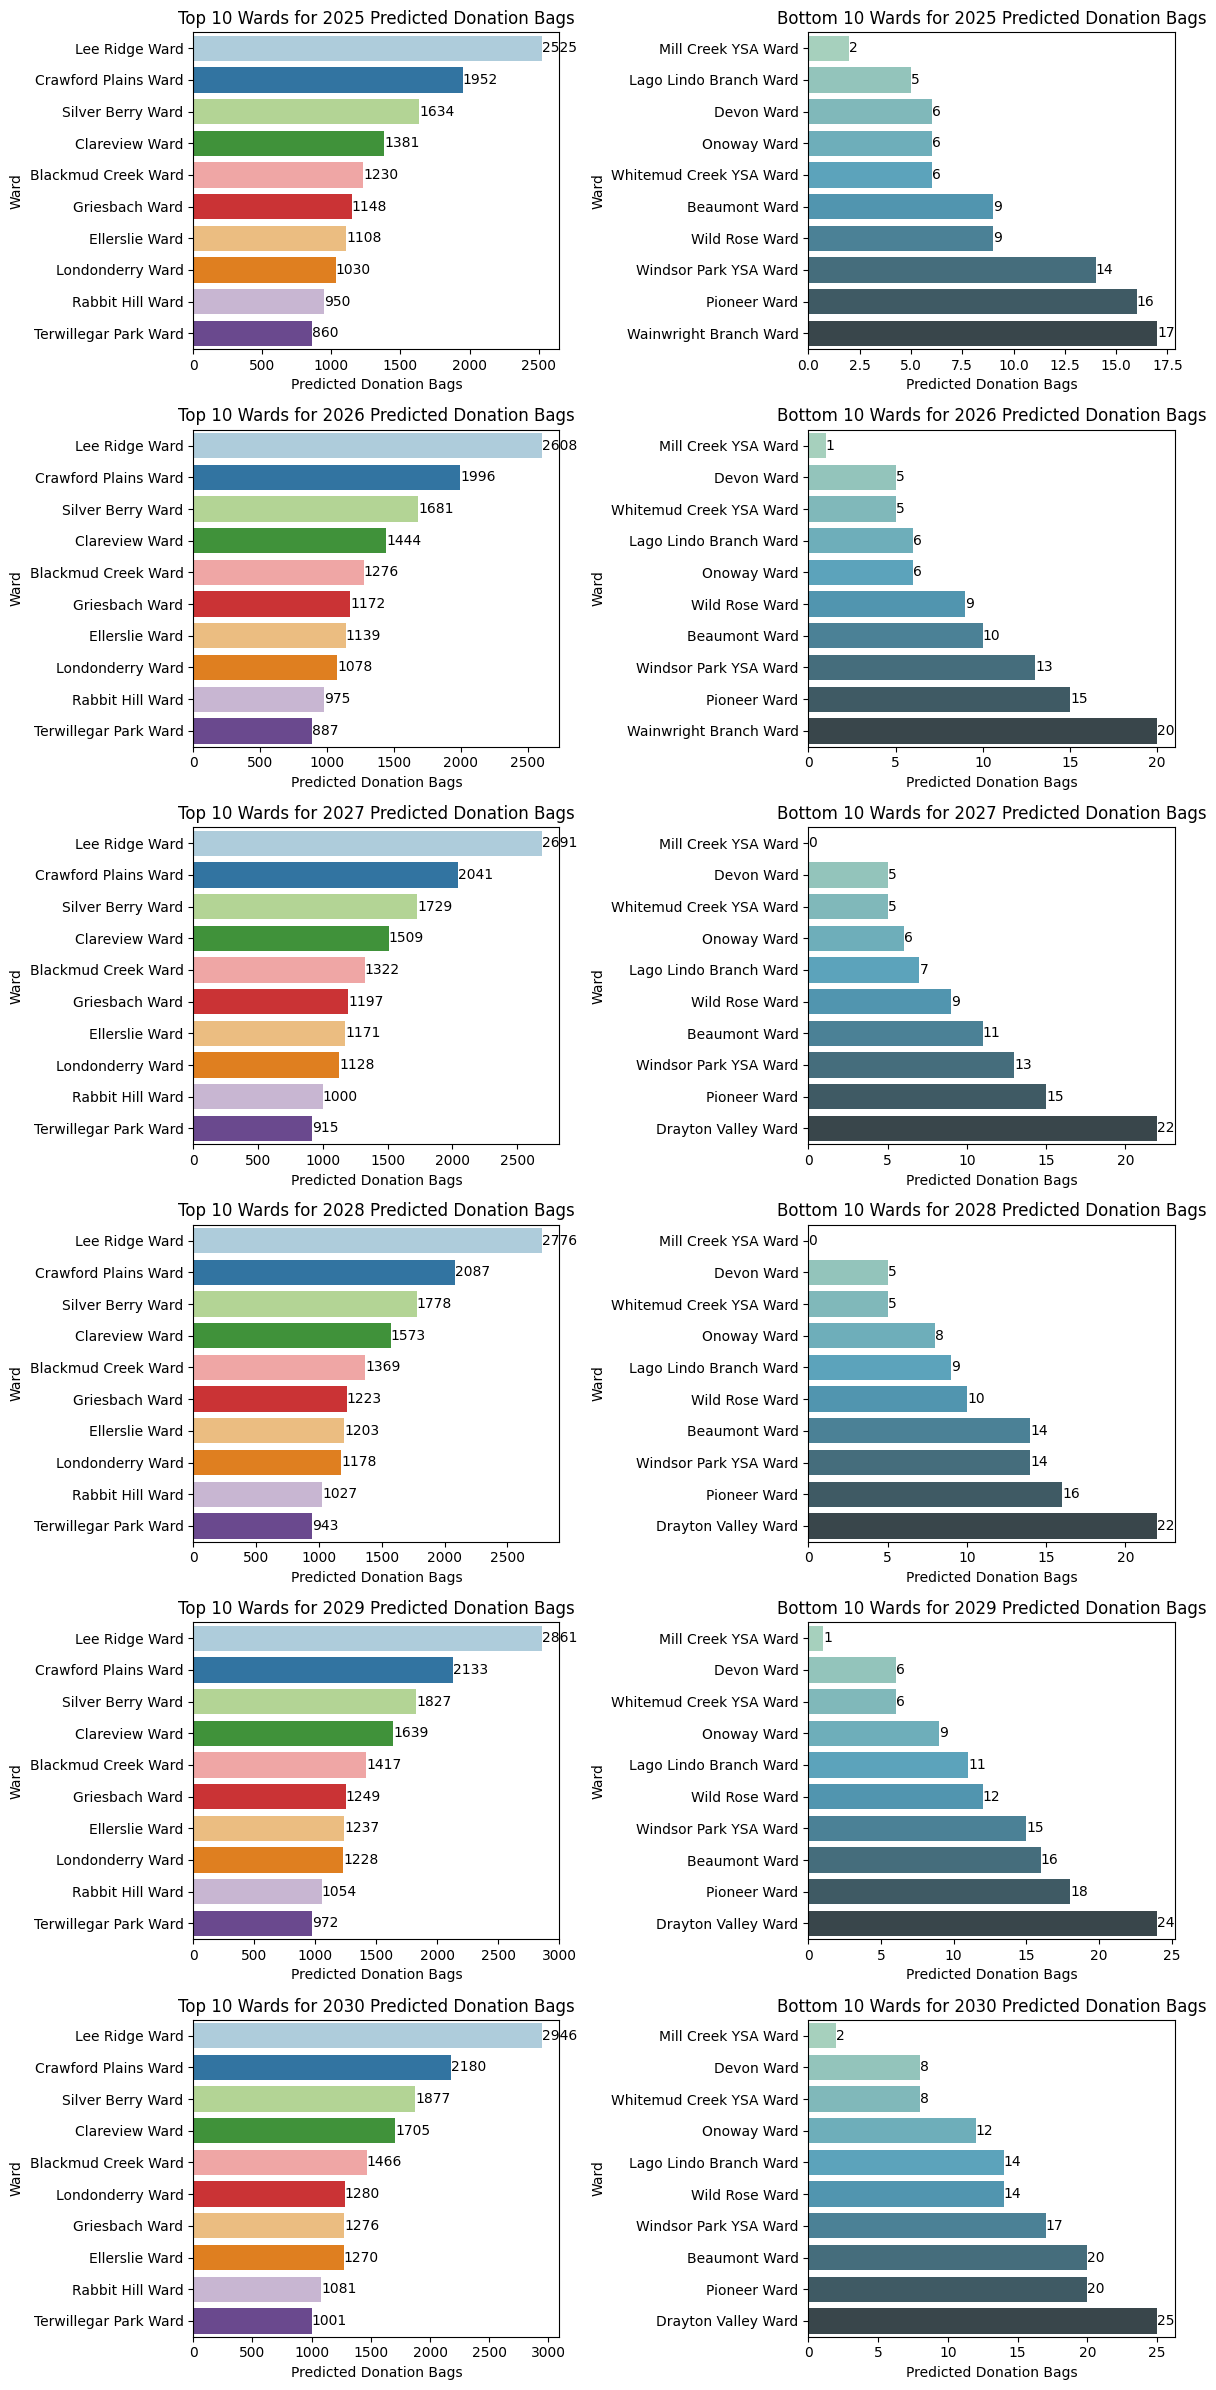

In [48]:
predictions_df['Predicted Donation Bags'] = predictions_df['Predicted Donation Bags'].clip(lower=0)

years = list(range(2025, 2031))

n_metrics = len(years)
fig, axes = plt.subplots(nrows=n_metrics, ncols=2, figsize=(12, n_metrics * 4))

for i, year in enumerate(years):
    top_10_wards = predictions_df[predictions_df['Year'] == year].nlargest(10, 'Predicted Donation Bags')
    bottom_10_wards = predictions_df[predictions_df['Year'] == year].nsmallest(10, 'Predicted Donation Bags')

    top_10_wards_sorted = top_10_wards.sort_values(by='Predicted Donation Bags', ascending=False)
    bottom_10_wards_sorted = bottom_10_wards.sort_values(by='Predicted Donation Bags', ascending=True)

    sns.barplot(x='Predicted Donation Bags', y='Ward', data=top_10_wards_sorted, ax=axes[i][0], palette='Paired', order=top_10_wards_sorted['Ward'])
    axes[i][0].set_title(f'Top 10 Wards for {year} Predicted Donation Bags')
    axes[i][0].set_xlabel('Predicted Donation Bags')
    axes[i][0].set_ylabel('Ward')

    for index, value in enumerate(top_10_wards_sorted['Predicted Donation Bags']):
        axes[i][0].text(value, index, f'{value}', va='center')

    sns.barplot(x='Predicted Donation Bags', y='Ward', data=bottom_10_wards_sorted, ax=axes[i][1], palette='GnBu_d', order=bottom_10_wards_sorted['Ward'])
    axes[i][1].set_title(f'Bottom 10 Wards for {year} Predicted Donation Bags')
    axes[i][1].set_xlabel('Predicted Donation Bags')
    axes[i][1].set_ylabel('Ward')

    for index, value in enumerate(bottom_10_wards_sorted['Predicted Donation Bags']):
        axes[i][1].text(value, index, f'{value}', va='center')

plt.tight_layout()
plt.show()


Here are the top 3 and bottom 3 stakes.

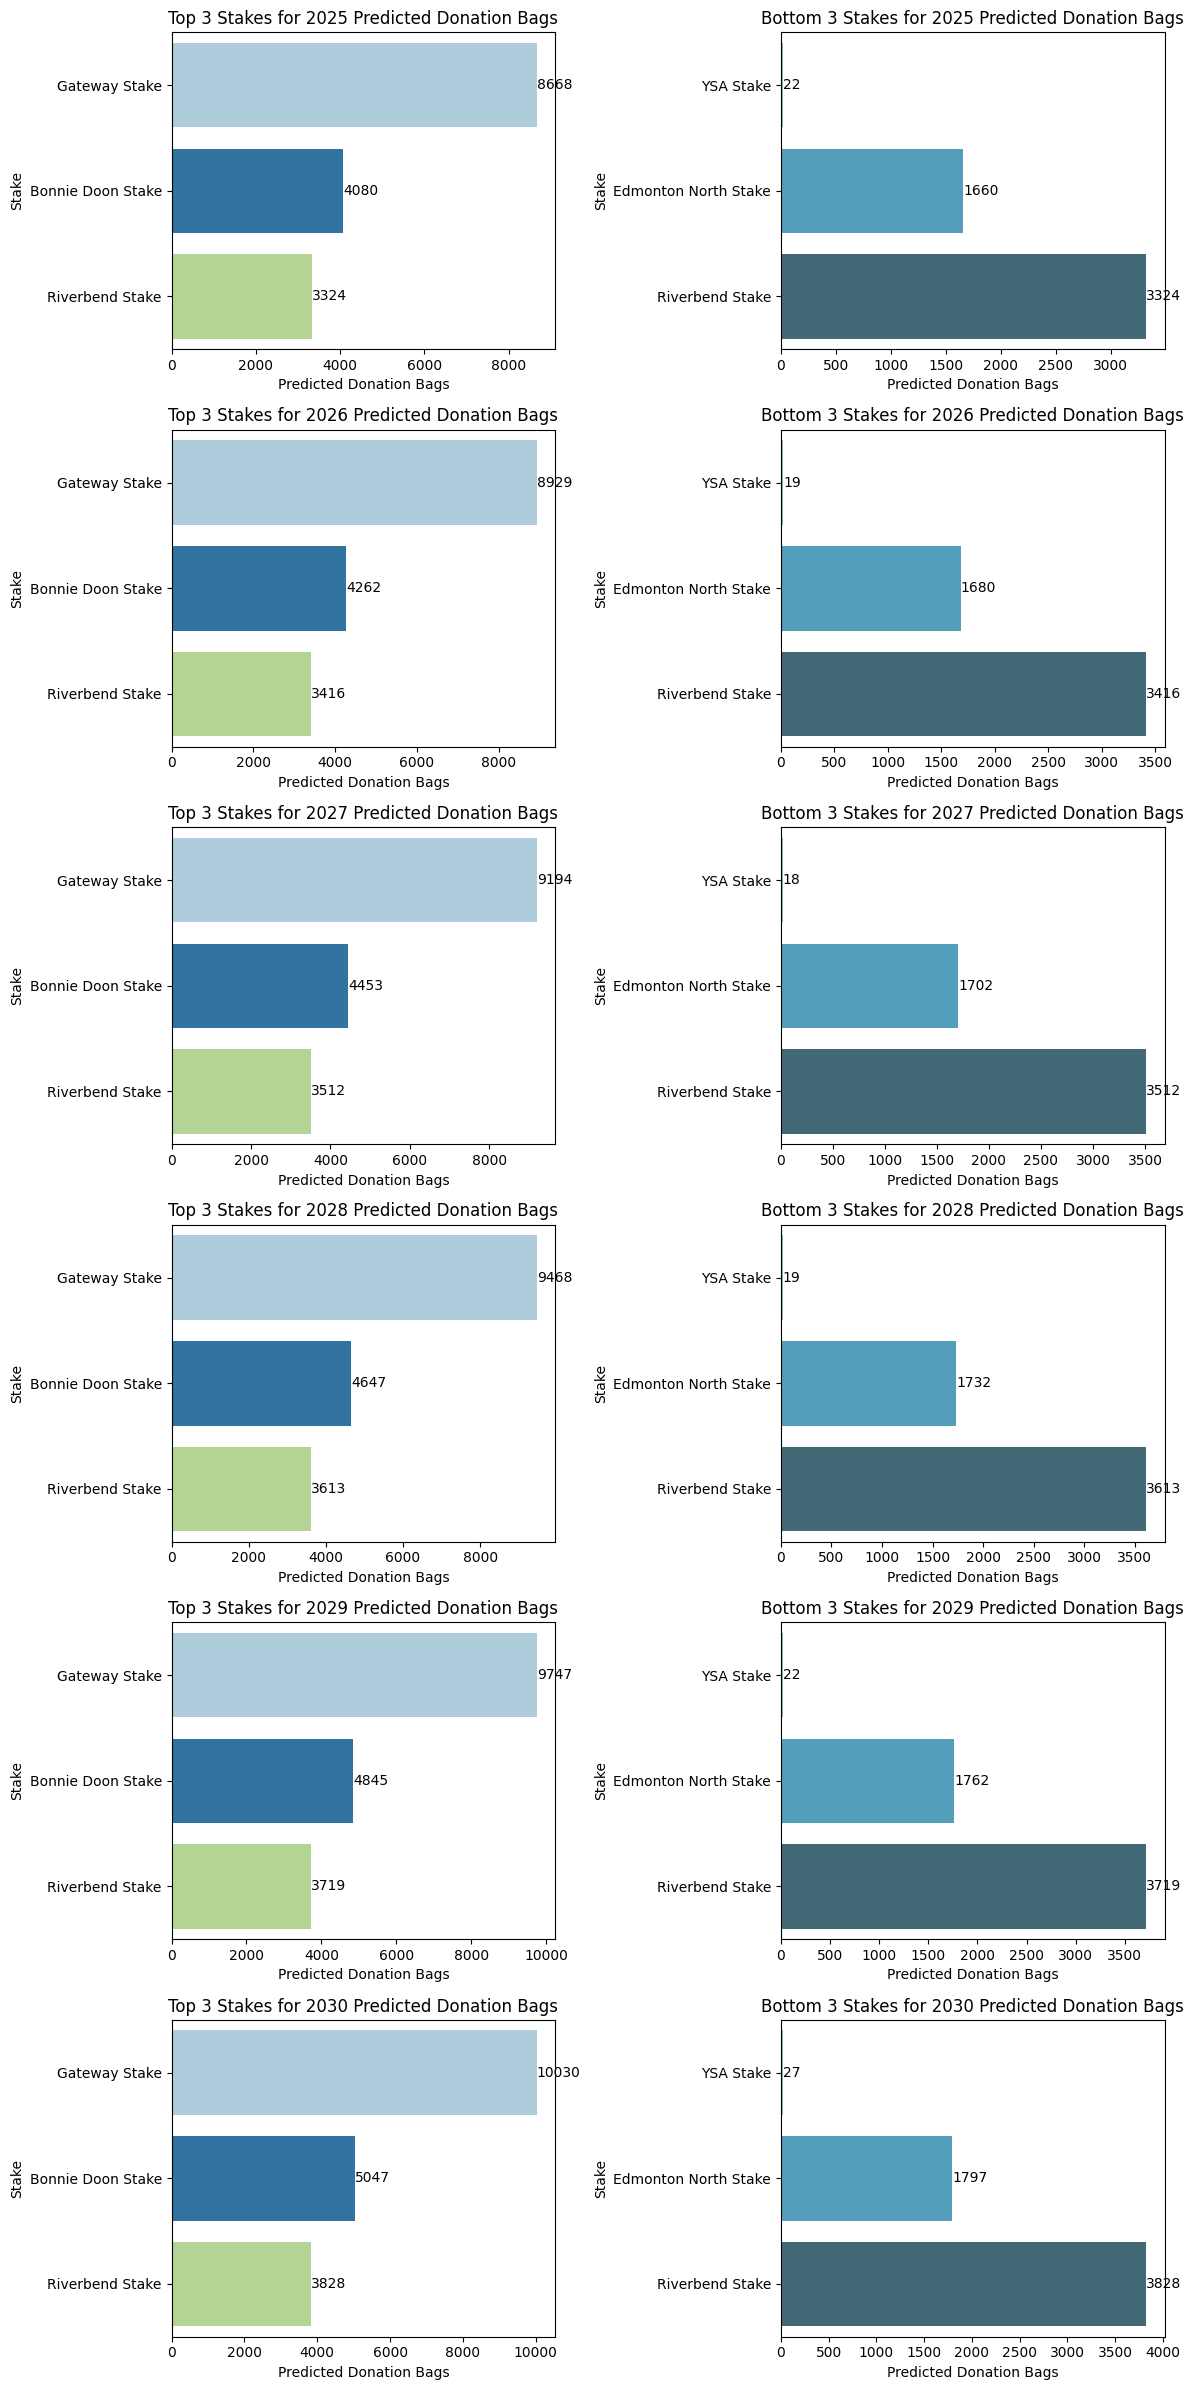

In [49]:
stake_mapping = {
    'Clareview Ward': 'Bonnie Doon Stake',
    'Connors Hill Ward': 'Bonnie Doon Stake',
    'Coronation Park Ward': 'Bonnie Doon Stake',
    'Forest Heights Ward': 'Bonnie Doon Stake',
    'Londonderry Ward': 'Bonnie Doon Stake',
    'Southgate Ward': 'Bonnie Doon Stake',
    'Strathcona Married Student Ward': 'Bonnie Doon Stake',

    'Griesbach Ward': 'Edmonton North Stake',
    'Lago Lindo Branch Ward': 'Edmonton North Stake',
    'Namao Ward': 'Edmonton North Stake',
    'Onoway Ward': 'Edmonton North Stake',
    'Pioneer Ward': 'Edmonton North Stake',
    'Stony Plain Ward': 'Edmonton North Stake',

    'Beaumont Ward': 'Gateway Stake',
    'Blackmud Creek Ward': 'Gateway Stake',
    'Crawford Plains Ward': 'Gateway Stake',
    'Ellerslie Ward': 'Gateway Stake',
    'Lee Ridge Ward': 'Gateway Stake',
    'Rio Vista Ward': 'Gateway Stake',
    'Silver Berry Ward': 'Gateway Stake',
    'Wainwright Branch Ward': 'Gateway Stake',
    'Wild Rose Ward': 'Gateway Stake',

    'Devon Ward': 'Riverbend Stake',
    'Drayton Valley Ward': 'Riverbend Stake',
    'Greenfield Ward': 'Riverbend Stake',
    'Rabbit Hill Ward': 'Riverbend Stake',
    'Rutherford Ward': 'Riverbend Stake',
    'Terwillegar Park Ward': 'Riverbend Stake',
    'Woodbend Ward': 'Riverbend Stake',

    'Mill Creek YSA Ward': 'YSA Stake',
    'Whitemud Creek YSA Ward': 'YSA Stake',
    'Windsor Park YSA Ward': 'YSA Stake'
}

predictions_df['Stake'] = predictions_df['Ward'].map(stake_mapping)
predictions_df['Stake'].fillna('Unknown', inplace=True)
years = list(range(2025, 2031))

n_metrics = len(years)
fig, axes = plt.subplots(nrows=n_metrics, ncols=2, figsize=(12, n_metrics * 4))

for i, year in enumerate(years):
    top_3_stakes = predictions_df[predictions_df['Year'] == year].groupby('Stake')['Predicted Donation Bags'].sum().nlargest(3).reset_index()
    bottom_3_stakes = predictions_df[predictions_df['Year'] == year].groupby('Stake')['Predicted Donation Bags'].sum().nsmallest(3).reset_index()

    top_3_stakes_sorted = top_3_stakes.sort_values(by='Predicted Donation Bags', ascending=False)
    bottom_3_stakes_sorted = bottom_3_stakes.sort_values(by='Predicted Donation Bags', ascending=True)

    sns.barplot(x='Predicted Donation Bags', y='Stake', data=top_3_stakes_sorted, ax=axes[i][0], palette='Paired', order=top_3_stakes_sorted['Stake'])
    axes[i][0].set_title(f'Top 3 Stakes for {year} Predicted Donation Bags')
    axes[i][0].set_xlabel('Predicted Donation Bags')
    axes[i][0].set_ylabel('Stake')

    for index, value in enumerate(top_3_stakes_sorted['Predicted Donation Bags']):
        axes[i][0].text(value, index, f'{value}', va='center')

    sns.barplot(x='Predicted Donation Bags', y='Stake', data=bottom_3_stakes_sorted, ax=axes[i][1], palette='GnBu_d', order=bottom_3_stakes_sorted['Stake'])
    axes[i][1].set_title(f'Bottom 3 Stakes for {year} Predicted Donation Bags')
    axes[i][1].set_xlabel('Predicted Donation Bags')
    axes[i][1].set_ylabel('Stake')

    for index, value in enumerate(bottom_3_stakes_sorted['Predicted Donation Bags']):
        axes[i][1].text(value, index, f'{value}', va='center')

plt.tight_layout()
plt.show()


Now lets get the totals per year.

In [50]:
grouped_predictions_df = predictions_df.groupby('Year', as_index=False)['Predicted Donation Bags'].sum()
grand_total = pd.DataFrame({'Year': ['Grand Total'], 'Predicted Donation Bags': [grouped_predictions_df['Predicted Donation Bags'].sum()]})
grouped_predictions_df = pd.concat([grouped_predictions_df, grand_total], ignore_index=True)
grouped_predictions_df

,Year,Predicted Donation Bags
0,2025,17754
1,2026,18306
2,2027,18879
3,2028,19479
4,2029,20095
5,2030,20729
6,Grand Total,115242


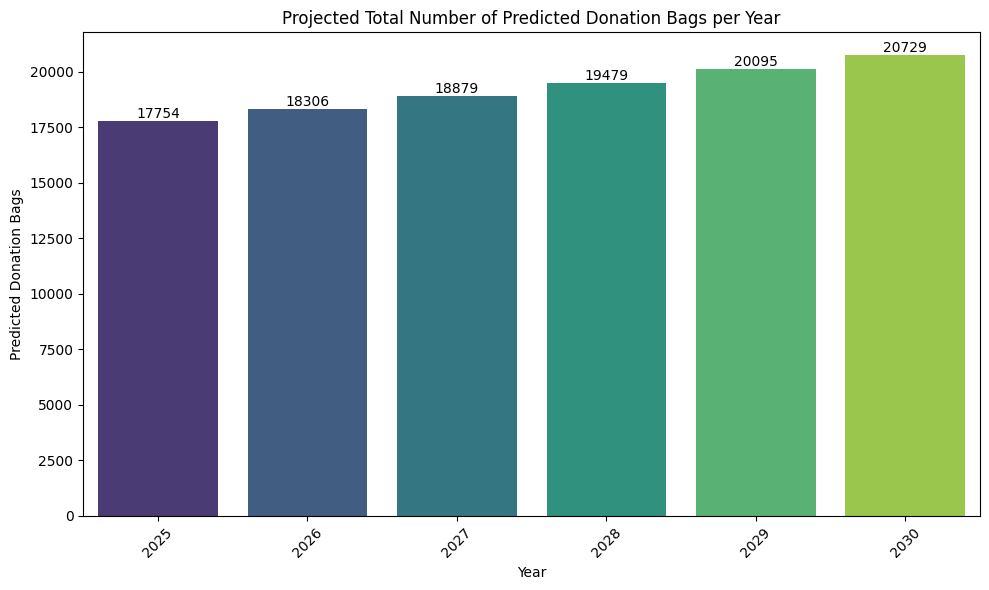

In [51]:
filtered_grouped_predictions_df = grouped_predictions_df.iloc[0:6]
plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='Predicted Donation Bags', data=filtered_grouped_predictions_df, palette='viridis')
plt.title('Projected Total Number of Predicted Donation Bags per Year')
plt.xlabel('Year')
plt.ylabel('Predicted Donation Bags')

for index, value in enumerate(filtered_grouped_predictions_df['Predicted Donation Bags']):
    plt.text(index, value, f'{value}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now lets get the totals per Stake.

In [52]:
grouped_df = predictions_df.groupby(['Stake', 'Year'], as_index=False)['Predicted Donation Bags'].sum()
df_pivoted = grouped_df.pivot(index='Stake', columns='Year', values='Predicted Donation Bags')
df_pivoted = df_pivoted.fillna(0)
df_pivoted

Year,2025,2026,2027,2028,2029,2030
Stake,,,,,,
Bonnie Doon Stake,4080,4262,4453,4647,4845,5047
Edmonton North Stake,1660,1680,1702,1732,1762,1797
Gateway Stake,8668,8929,9194,9468,9747,10030
Riverbend Stake,3324,3416,3512,3613,3719,3828
YSA Stake,22,19,18,19,22,27


Now lets get the totals per Wards.

In [53]:
grouped_df = predictions_df.groupby(['Ward', 'Year'], as_index=False)['Predicted Donation Bags'].sum()
df_pivoted = grouped_df.pivot(index='Ward', columns='Year', values='Predicted Donation Bags')
df_pivoted = df_pivoted.fillna(0)
df_pivoted

Year,2025,2026,2027,2028,2029,2030
Ward,,,,,,
Beaumont Ward,9,10,11,14,16,20
Blackmud Creek Ward,1230,1276,1322,1369,1417,1466
Clareview Ward,1381,1444,1509,1573,1639,1705
Connors Hill Ward,420,432,445,459,473,488
Coronation Park Ward,198,207,218,229,241,253
Crawford Plains Ward,1952,1996,2041,2087,2133,2180
Devon Ward,6,5,5,5,6,8
Drayton Valley Ward,23,22,22,22,24,25
Ellerslie Ward,1108,1139,1171,1203,1237,1270
